<a href="https://colab.research.google.com/github/yashwanthbooram/Object-Detection-in-Satellite-Imagery-Using-YOLOv3/blob/main/Object%20Detection%20in%20Satellite%20Imagery%20Using%20YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

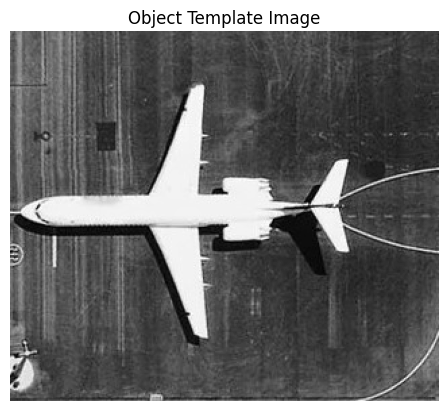

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image from file
image = cv2.imread('object_template.jpg', cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Object Template Image')
plt.show()


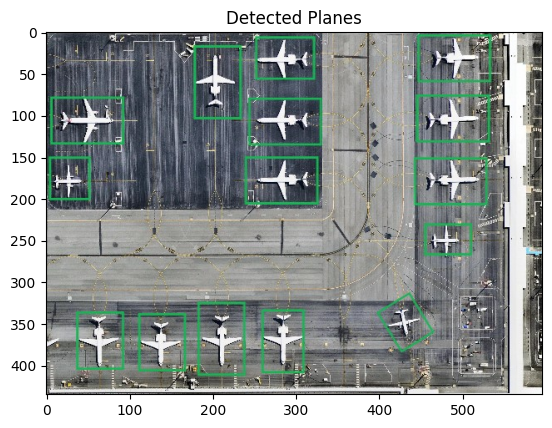

In [ ]:
import cv2
import numpy as np

# Load the satellite image
image = cv2.imread('satellite_image1.jpg')

# Convert the satellite image to grayscale
image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load the template of a plane and convert it to grayscale
template = cv2.imread('object_template.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure both images are in the correct data type
image_grayscale = np.uint8(image_grayscale)
template = np.uint8(template)

# Resize the template image to match the dimensions of the satellite image
template = cv2.resize(template, (image_grayscale.shape[1], image_grayscale.shape[0]))

# Match the template in the image
result = cv2.matchTemplate(image_grayscale, template, cv2.TM_SQDIFF)

# Specify a threshold to filter out weak detections
threshold = 1  # Adjust the threshold as needed
locations = np.where(result <= threshold)

# Draw rectangles around the detected planes
w, h = template.shape[::-1]
for pt in zip(*locations[::-1]):
    cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
import matplotlib.pyplot as plt

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Planes')
plt.axis('off')  # Turn off axis labels
plt.show()



In [ ]:
**Connect google drive**
# To Check GPU
!nvidia-smi
**1) Clone the Darknet**


# Clone the Darknet to the Colab
!git clone https://github.com/AlexeyAB/darknet



**2) Configure Darknet network for training YOLO V3**


In [ ]:
# Configuration file (cfg file)
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg
# Setting for single object

!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg
# Create folder on google drive so that we can save there the weights
!mkdir "/mydrive/yolov3/"
# Jet is a class name
!echo "Jet" > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3/' > data/obj.data
!mkdir data/obj
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

**3) Extract Images**


In [ ]:

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "yolov3" on Google Drive
# Extracting custom object dataset
!unzip /mydrive/yolov3/images.zip -d data/obj
# We're going to convert the class index on the .txt files. As we're working with only one class, it's supposed to be class 0.
# If the index is different from 0 then we're going to change it.
import glob
import os
import re

txt_file_paths = glob.glob(r"data/obj/*.txt")
for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()

        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:

                # Define coordinates
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Write file
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)
import glob
images_list = glob.glob("data/obj/images/*.jpg")
print(images_list)
#Create training.txt file, required for YOLOv3 training
file = open("data/train.txt", "w")
file.write("\n".join(images_list))
file.close()
# Calculates anchors for the custom dataset
!./darknet detector calc_anchors data/obj.data -num_of_clusters 9 -width 608 -height 608


**4) Start the training**


In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show
# Training on last saved weights
!./darknet detector train data/obj.data cfg/yolov3_training.cfg '/content/gdrive/My Drive/yolov3/yolov3_training_last.weights' -dont_show
# Testing on an image
!./darknet detect cfg/yolov3_testing.cfg '/content/gdrive/My Drive/yolov3/yolov3_training_final.weights' data/Test_img.jpg
# Mean Average Precision (mAP) Calculation
!./darknet detector map data/obj.data cfg/yolov3_training.cfg '/content/gdrive/My Drive/yolov3/yolov3_trained.weights'